##1. Important Libraries

In [279]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Binarizer

##2. Load and Prepare the Dataset

In [280]:
data = 'lung_cancer_prediction_dataset.csv'

# 2. Then load the data
import pandas as pd
df = pd.read_csv(data)

##3. Create and Transform Features python Copy Edit

In [281]:
df["Smoking_Index"] = df["Years_of_Smoking"] * df["Cigarettes_per_Day"]


In [282]:
# Convert Yes/No or Male/Female to 0/1
df['Cancer'] = df['Lung_Cancer_Diagnosis'].apply(lambda x: 0 if x == 'No' else 1)
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
df['Smoker'] = df['Smoker'].apply(lambda x: 0 if x == 'No' else 1)
df['Passive_Smoker'] = df['Passive_Smoker'].apply(lambda x: 0 if x == 'No' else 1)
df["Family_History"] = df["Family_History"].apply(lambda x: 0 if x == 'No' else 1)
df["Healthcare_Access"] = df["Healthcare_Access"].apply(lambda x: 0 if x == 'Good' else 1)
df["Developed_or_Developing"] = df["Developed_or_Developing"].apply(lambda x: 0 if x == 'Developing' else 1)
df['Occupational_Exposure'] = df['Occupational_Exposure'].apply(lambda x: 0 if x == 'No' else 1)
df['Indoor_Pollution'] = df['Indoor_Pollution'].apply(lambda x: 0 if x == 'No' else 1)
df['Air_Pollution_Exposure'] = df['Air_Pollution_Exposure'].map({"Low": 0, "Medium": 1, "High": 2})


## 4. Split Cancer vs Non-Cancer Patients

In [283]:
cancer_df = df[df['Cancer'] == 1]
no_cancer_df = df[df['Cancer'] == 0]


##5. Sample Balanced Subsets (50% each)

In [284]:
num_cancer = int(15000 * 0.50)
num_no_cancer = int(15000 * 0.50)

cancer_sample = cancer_df.sample(n=num_cancer, random_state=42)
no_cancer_sample = no_cancer_df.sample(n=num_no_cancer, random_state=42)


## 6. Assign Random Survival Years to Some Non-Cancer Patients

In [285]:
num_rows_to_modify = 158
rows_to_modify = no_cancer_sample.sample(n=num_rows_to_modify, random_state=42).index

np.random.seed(42)  # ✅ Ensure consistent random survival years
no_cancer_sample.loc[rows_to_modify, "Survival_Years"] = np.random.randint(1, 20, size=num_rows_to_modify)

## 7. Merge Samples & Shuffle Rows

In [286]:
filtered_df = pd.concat([cancer_sample, no_cancer_sample])
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

##8. (Optional) One-hot encode pollution exposure

In [287]:
df = pd.get_dummies(df, columns=["Air_Pollution_Exposure"], drop_first=True)

## 9. Save Final Clean Dataset

In [288]:
filtered_df.to_csv('filtered_dataset.csv', index=False)


##10. Define Target and Features for Modeling

In [289]:
y = filtered_df['Cancer']
X = filtered_df.drop(columns=[
    'ID', 'Population_Size', 'Country', 'Cancer', 'Lung_Cancer_Diagnosis',
    'Cancer_Stage', 'Adenocarcinoma_Type', 'Early_Detection', 'Treatment_Type',
    'Annual_Lung_Cancer_Deaths', 'Lung_Cancer_Prevalence_Rate', 'Mortality_Rate'
])


##11. Loading the Filtered Dataset

In [290]:
X

,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Survival_Years,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Developed_or_Developing,Smoking_Index
0,76,0,0,0,0,0,0,0,1,0,1,1,0,0
1,33,1,1,34,14,0,0,9,1,1,0,1,0,476
2,81,0,0,0,0,0,0,0,1,0,0,1,0,0
3,33,0,0,0,0,0,0,10,1,0,0,1,0,0
4,81,1,1,38,21,0,0,8,0,0,0,0,1,798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,34,1,0,0,0,0,1,3,1,1,0,1,0,0
14996,52,1,0,0,0,0,0,0,0,0,0,1,0,0
14997,84,0,1,12,8,0,0,2,1,1,0,1,0,96
14998,79,1,1,38,12,0,0,6,2,0,1,1,0,456


## 12. Plot the Correlation Heat Map

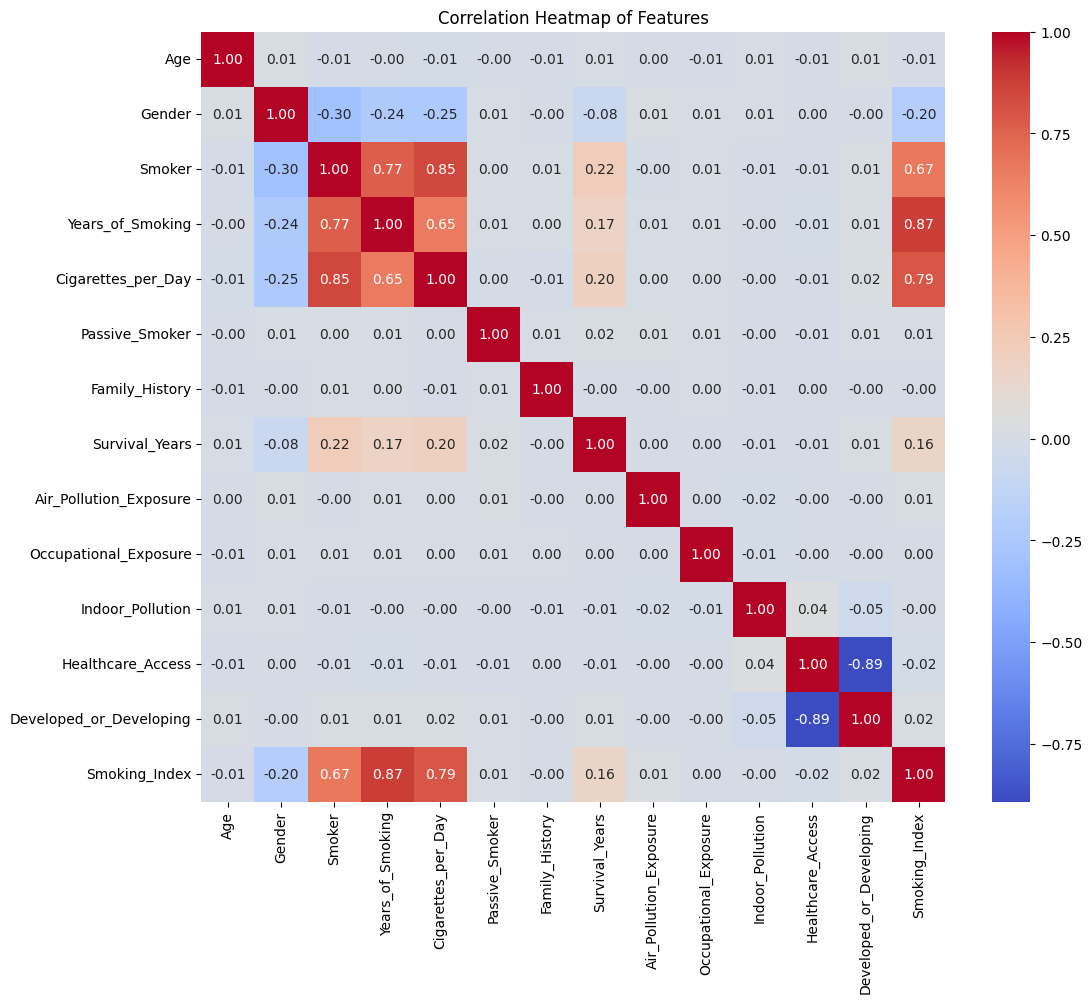

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X' is your DataFrame as defined in the previous code.
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()


##13. Splitting the Filtered Dataset to Train and Test

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##14. Model Evaluation
##Since  Bayesian Ridge is a regression model, it outputs probabilities-like values, not class labels. So, the predictions must be thresholded manually to turn them into actual class labels. For instance, the Bayesian Ridge gives results like:[0.12, 0.60, 0.45, 0.81, 0.33] which are not class labels, they are scores or probabilities. So we need a cut-off point — that’s what the threshold is.

##Threshold 0.45 means:

"If the predicted value is greater than or equal to 0.45, call it 1 (Cancer).
Otherwise, call it 0 (No Cancer)."

In [293]:
from sklearn.linear_model import BayesianRidge

# Train the model
bayes_ridge = BayesianRidge()
bayes_ridge.fit(X_train, y_train)

# Predict on test data
y_pred_bayes_ridge = bayes_ridge.predict(X_test)

# Convert predictions to 0 or 1 using threshold 0.45
y_pred_bayes_ridge = (y_pred_bayes_ridge >= 0.45).astype(int)

# Evaluate accuracy
accuracy_bayes_ridge = accuracy_score(y_test, y_pred_bayes_ridge)
print(f"Accuracy: {accuracy_bayes_ridge:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bayes_ridge))

Accuracy: 0.9133

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      2257
           1       0.98      0.84      0.91      2243

    accuracy                           0.91      4500
   macro avg       0.92      0.91      0.91      4500
weighted avg       0.92      0.91      0.91      4500



#Based on the result: The model got 91.33% of all predictions correct. Out of 4,500 patients(The classification report shows support:
#4500 patients(rows) because we created a filtered dataset of 15000/2=7500, then we considered test_size=.3. So 7500*.3 = 4500 rows (e.g., 2250 cancer + 2250 no cancer), not 7,500.). Now the Bayesian Ridge model shows that about 4,110 were correctly classified (either as cancer or no cancer).

#Class 0: No Cancer

#Class 1: Cancer

#Let me break it down deeply:

#precision: 0.86
#recall:    0.98
#f1-score:  0.92
#support:   2257

#Precision (86%): When the model said No Cancer, it was right 86% of the time.

#Recall (98%): Out of all actual No Cancer patients, it found 98% of them correctly.

#F1-score (92%): A balance between precision and recall.

#Support: 2257 people in this group (actual No Cancer cases).


##15. Plot the Confusion Matrix


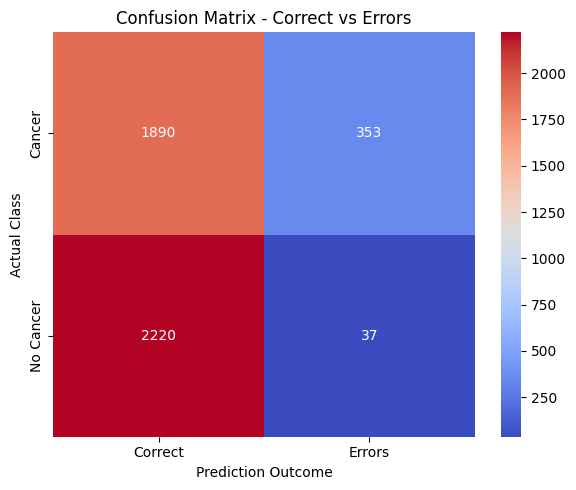

In [294]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Standard confusion matrix
cm = confusion_matrix(y_test, y_pred_bayes_ridge)

# Create custom matrix:
# Rows: Actual Cancer, Actual No Cancer
# Columns: Correct Predictions | Errors
custom_cm = np.array([
    [cm[1, 1], cm[1, 0]],  # [True Positives, False Negatives]
    [cm[0, 0], cm[0, 1]]   # [True Negatives, False Positives]
])

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(custom_cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Correct', 'Errors'],
            yticklabels=['Cancer', 'No Cancer'])
plt.title('Confusion Matrix - Correct vs Errors')
plt.xlabel('Prediction Outcome')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

##Based on the Confusion Matrix Result:
2220 people who didn't have cancer were correctly predicted

37 people who didn't have cancer were wrongly predicted to have cancer

1963 people who did have cancer were correctly identified

280 people who did have cancer were missed

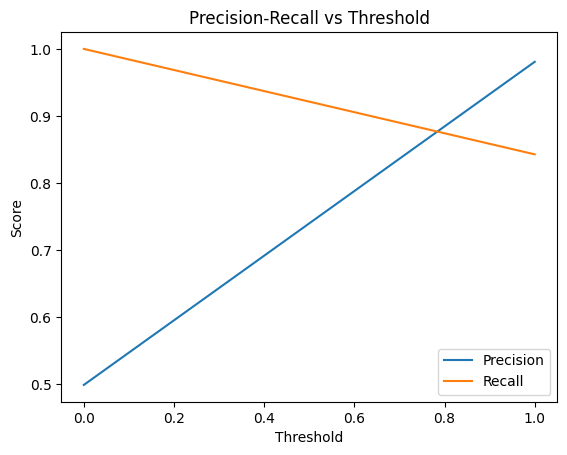

In [295]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_bayes_ridge)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()